# LLM - Bielik - Fine tuning - part II

## Introduction 

This is second part of small series related to LLM fine-tuning!

The goal of following article is to fine-tuning one large language model - Bielik 7B from Speakleash <page>. In first part <link to first part> we focused on data preparation. To achieve this, we generated data based on the polish legal document. Then, we measured the quality of the generated data using various metrics (distance and LLM based). As we proved the good quality of the generated question and answers based on the context, we formatted the data in order to follow a specific schema suitable for question-answering task for LLM.

Now let's deep dive into the fine-tuning itself!


# Prerequisites

In order to start working with model and finetuning let's install required libraries (also present in requirements.txt). Short intro to libraries:
- bitandbytes - setups config for quantization options
- transformers - core library for using Large Language Models and beyond
- accelerate - <em>Accelerate is a library that enables the same PyTorch code to be run across any distributed configuration by adding just four lines of code.</em> https://huggingface.co/docs/accelerate/en/index
- peft - our gem! <strong>P</strong>aremeter-<strong>E</strong>fficient <strong>F</strong>ine <strong>T</strong>uning library which allows to finetune small number of extra model paremeters instead of all which could be costly.
- wandb - weights and biases - useful for tracking the experiments (https://wandb.ai/site/)
- torch, torchvision, torchaudio - core PyTorch libraries for running neural networks.

In [ ]:
# ! pip install bitsandbytes
# ! pip install transformers
# ! pip install accelerate
# ! pip install peft
# ! pip install wandb
# ! pip install datasets
# ! pip install ipywidgets==8.1.3
# ! pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124

In [15]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, logging
import transformers
from datetime import datetime
from accelerate import Accelerator
from huggingface_hub import notebook_login
from peft import prepare_model_for_kbit_training, PeftModel, LoraConfig, get_peft_model
from src.helpers.models import load_model
from src.helpers.data import load_data, generate_and_tokenize, plot_hist, generate_and_tokenize_with_truncation

## 3...2...1...action!
Let's start with some helper functions:
- setting appropriate level of logging, because pytorch likes to spam all the output console.
- login to huggingface with credentials to be able to download some models - not every model is available without logging in.

In [16]:
logging.set_verbosity_warning()
notebook_login()

To start with, let's focus on our model. Here, we want to load and setup appropriate model, Bielik 7B in our case. We start with quantization config in order to make our model lighter. Then we use a helper function to get the model from HuggingFace Hub.

In [ ]:
model_config = {
        'load_in_4bit':True,
        'bnb_4bit_use_double_quant':True,
        'bnb_4bit_quant_type':"nf4",
        'bnb_4bit_compute_dtype':torch.bfloat16
}

model_name = 'speakleash/Bielik-7B-v0.1'

In [3]:
model, tokenizer = load_model(model_name, config=model_config)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Having the model and aligned tokenizer loaded, let's head to data. In previous part of this tutorial we focused on generating data, questions and answers, to use for training the model specific task like handling user questions. Now, we need to split our data for training and evaluation set. Here, we did this process manually, by spliting the dataset and creating two separate files - training and eval. In this case around 80% is training dataset and around 20% is eval dataset.

In [ ]:
train_data_path = 'ft_output_data/data_ft_20240818_133719_train.jsonl'
eval_data_path = 'ft_output_data/data_ft_20240818_133719_eval.jsonl'

In [ ]:
train_dataset = load_data(path=train_data_path, type='train', format='json')
eval_dataset = load_data(path=eval_data_path, type='train', format='json')

After loading the data to an specific format suitable for fine-tuning, we need to preprocess the input data to be used for QA task. Our data now will have format as follows: "### Question: <question>\n ### Answer: <answer>}". It will be also tokenized (transformed from words to numbers).

In [8]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize, fn_kwargs={"tokenizer": tokenizer})
tokenized_eval_dataset = eval_dataset.map(generate_and_tokenize, fn_kwargs={"tokenizer": tokenizer})

Map:   0%|          | 0/799 [00:00<?, ? examples/s]

Map:   0%|          | 0/225 [00:00<?, ? examples/s]

Let us verify how long our sentences are. In the first part of article about data generation, we asked GPT model to deliver answers with a limit of 200 tokens. We set this limit to instruct the model to provide concise answer within this number. Combining questions and answers gives us numbers as below:

1024


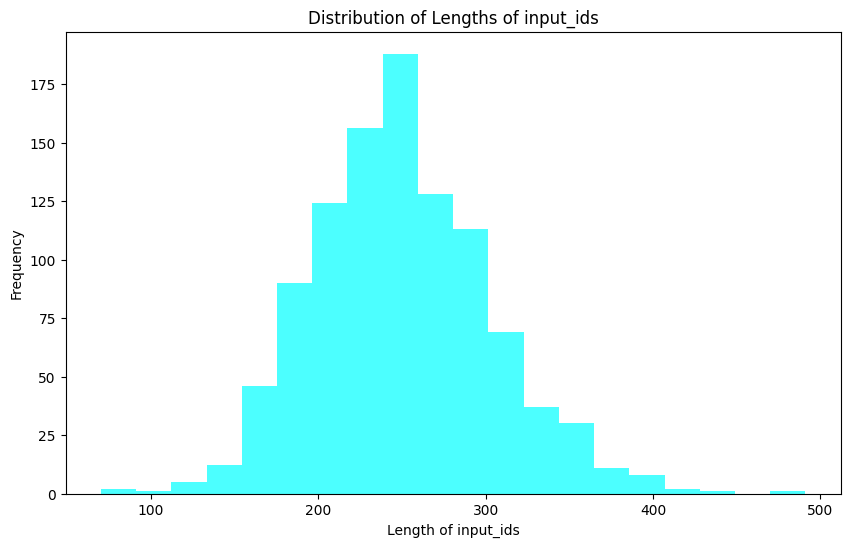

In [9]:
plot_hist(tokenized_train_dataset, tokenized_eval_dataset)

As shown, the majority of sentences are between 200 and 300 tokens in length. Now, for model usage we need to make all the sentences mand make them the same size. 

In [10]:
max_length = 512

In [11]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_with_truncation, fn_kwargs={"tokenizer": tokenizer, 'length': max_length})
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_with_truncation, fn_kwargs={"tokenizer": tokenizer, 'length': max_length})

Map:   0%|          | 0/799 [00:00<?, ? examples/s]

Map:   0%|          | 0/225 [00:00<?, ? examples/s]

1024


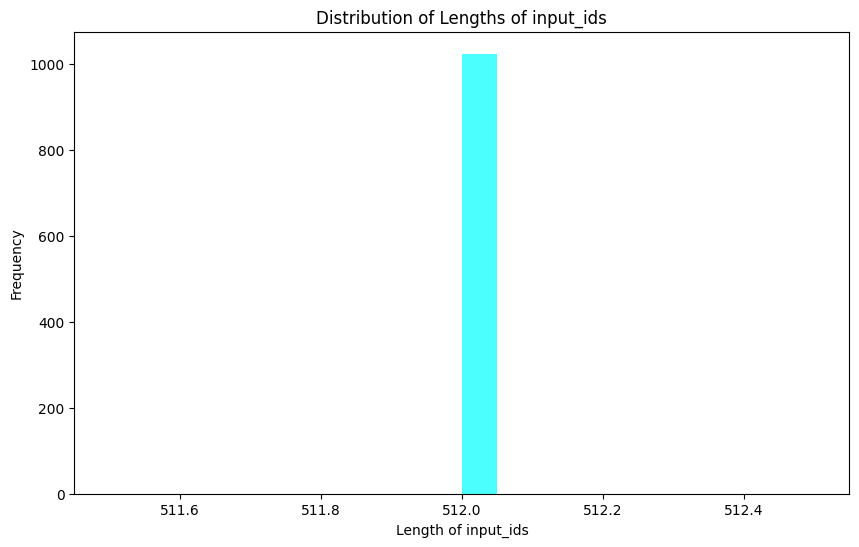

In [12]:
plot_hist(tokenized_train_dataset, tokenized_val_dataset)

To verify our fine tuning let's create a small validation dataset with question related to the topic of documents which we will use for fine-tuning. Additonally, let's add some questions which should verify if the model did not forget original capabilities.

In [ ]:
validation_questions = [
    'Jakie są zagrożenia zwiazane z umową?'
]

In [18]:
eval_tokenizer = AutoTokenizer.from_pretrained(
    model_name,
    add_bos_token=True,
)

model_input = eval_tokenizer(validation_questions[0], return_tensors="pt").to("cuda")

model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(model.generate(**model_input, max_new_tokens=512, repetition_penalty=1.15)[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Jakie są zagrożenia zwiazane z umową?
1. Umowa jest zawierana na czas nieokreślony, co oznacza, że może być wypowiedziana przez każdą ze stron bez podania przyczyny i terminu wypowiedzenia. W przypadku wypowiedzenia umowy przez bank lub kredytobiorcę, cała kwota kredytu staje się natychmiast wymagalna. Jeśli kredytobiorca nie spłaci kredytu w terminie, bank ma prawo postawić całą nieruchomość stanowiącą zabezpieczenie kredytu w stan natychmiastowej wymagalności poprzez dokonanie jej opisu i oszacowania według swojego uznania i obciążyć hipotekę dodatkowo odsetkami w wysokości 2-krotnej sumy stopy referencyjnej Narodowego Banku Polskiego oraz marży banku. Ponadto, jeśli kredytobiorca nie spłaci kredytu w terminie, bank będzie miał prawo dochodzić zapłaty we wszystkich postaciach dopuszczanych przez prawo cywilne.
2. Kredytobiorca ponosi ryzyko zmiany kursów walutowych. Zmienność kursów walutowych powoduje, że trudno precyzyjnie określić w chwili udzielenia kredytu hipotecznego denominow

In [19]:
model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

In [20]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [21]:
lora_params = {
    'r': 64,
    'alpha': 128,
    'layers': ["q_proj",
            "k_proj",
            "v_proj",
            "o_proj",
            "gate_proj",
            "up_proj",
            "down_proj",
            "lm_head"],
    'dropout': 0.05
}

linear_layers = ['gate_proj', 'down_proj', 'up_proj', 'q_proj', 'v_proj', 'k_proj','o_proj']

config = LoraConfig(
    r=lora_params.get('r'),
    lora_alpha=lora_params.get('alpha'),
    target_modules=lora_params.get('layers'),
    bias="none",
    lora_dropout=lora_params.get('dropout'),  # Conventional
    task_type="CAUSAL_LM",
)

model = get_peft_model(model, config)
print_trainable_parameters(model)

trainable params: 170082304 || all params: 3922153472 || trainable%: 4.336452033664837


In [22]:

accelerator = Accelerator()
model = accelerator.prepare_model(model)

In [23]:
project = "legal-finetune"
base_model_name = "bielik_v1"
params = f'r-{lora_params.get("r")}-alpha-{lora_params.get("alpha")}'
run_name = base_model_name + "-" + project + "-" + params
output_dir = "./" + run_name

trainer = transformers.Trainer(
    model=model,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    args=transformers.TrainingArguments(
        output_dir=output_dir,
        warmup_steps=2,
        per_device_train_batch_size=2,
        gradient_accumulation_steps=1,
        gradient_checkpointing=True,
        max_steps=500,
        learning_rate=2.5e-5, # Want a small lr for finetuning
        bf16=True,
        optim="sgd",
        logging_steps=25,              # When to start reporting loss
        logging_dir="./logs",        # Directory for storing logs
        save_strategy="steps",       # Save the model checkpoint every logging step
        save_steps=25,                # Save checkpoints every 50 steps
        evaluation_strategy="steps", # Evaluate the model every logging step
        eval_steps=25,               # Evaluate and save checkpoints every 50 steps
        do_eval=True,                # Perform evaluation at the end of training
        report_to="wandb",           # Comment this out if you don't want to use weights & baises
        run_name=f"{run_name}-{datetime.now().strftime('%Y-%m-%d-%H-%M')}"          # Name of the W&B run (optional)
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()

C:\Users\zjada\dev\projects\llm-bielik-ft-legal\venv\lib\site-packages\transformers\training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
max_steps is given, it will override any value given in num_train_epochs
wandb: Currently logged in as: zvit3k (zvit3k-kodio). Use `wandb login --relogin` to force relogin


C:\Users\zjada\dev\projects\llm-bielik-ft-legal\venv\lib\site-packages\torch\_dynamo\eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
C:\Users\zjada\dev\projects\llm-bielik-ft-legal\venv\lib\site-packages\torch\utils\checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]


Step,Training Loss,Validation Loss
25,1.075900,1.020677
50,1.033500,1.016016
75,1.069400,1.010600
100,1.044600,1.004614
125,1.039500,0.998606
150,1.036500,0.993411
175,0.993500,0.986732
200,1.042000,0.983343
225,0.991500,0.979121
250,1.024800,0.974872


C:\Users\zjada\dev\projects\llm-bielik-ft-legal\venv\lib\site-packages\peft\utils\save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
C:\Users\zjada\dev\projects\llm-bielik-ft-legal\venv\lib\site-packages\torch\_dynamo\eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
C:\Users\zjada\dev\projects\llm-bielik-ft-legal\venv\lib\site-packages\torch\utils\checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torc

TrainOutput(global_step=500, training_loss=1.01540193939209, metrics={'train_runtime': 1249.4976, 'train_samples_per_second': 0.8, 'train_steps_per_second': 0.4, 'total_flos': 2.23440742121472e+16, 'train_loss': 1.01540193939209, 'epoch': 1.25})

In [24]:
base_model_id = "speakleash/Bielik-7B-v0.1"
bnb_config = BitsAndBytesConfig(
    # llm_int8_enable_fp32_cpu_offload=True,
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

base_model = AutoModelForCausalLM.from_pretrained(
    base_model_id,  # Mistral, same as before
    quantization_config=bnb_config,  # Same quantization config as before
    device_map="auto",
    trust_remote_code=True
)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [25]:
eval_tokenizer = AutoTokenizer.from_pretrained(base_model_id, add_bos_token=True, trust_remote_code=True)

In [26]:
ft_model = PeftModel.from_pretrained(base_model, "bielik_v1-legal-finetune-r-64-alpha-128/checkpoint-500")

In [ ]:
# eval_tokenizer.apply_chat_template(return_tensors="pt")

In [27]:
evaluation_prompt = "W jaki sposób przedsiębiorca może udowodnić, że nie znał danego publicznego zapewnienia i rozsądnie nie mógł o nim wiedzieć?"
model_input = eval_tokenizer(evaluation_prompt, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=600, repetition_penalty=1.15)[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


W jaki sposób przedsiębiorca może udowodnić, że nie znał danego publicznego zapewnienia i rozsądnie nie mógł o nim wiedzieć?
W przypadku gdy konsument skorzystał z prawa odstąpienia od umowy zawartej na odległość lub poza lokalem przedsiębiorcy, a następnie wyraził zgodę na dodatkowe świadczenia ze strony przedsiębiorcy (np. na zakup produktu promocyjnego), to przedsiębiorca ma prawo dochodzić zwrotu tych świadczeń za zapłatą ich wartości rynkowej. Przedsiębiorca musi jednak udowodnić, że konsument był świadomy swojej decyzji oraz że został on poinformowany przez przedsiębiorcę o utracie prawa odstąpienia od umowy wskutek wyrażenia zgody na dodatkowe świadczenie. Zatem jeśli przedsiębiorca chce dochodzić zwrotu takich świadczeń, powinien wykazać, że spełnione są łącznie trzy warunki:
1) konsument został poinformowany przez przedsiębiorcę o utracie prawa odstąpienia od umowy;
2) konsument miał świadomość konsekwencji prawnych wynikających z wyrażenia zgody na dodatkowe świadczenie;
3) k